# Expected SARSA and Actor-Critic Lunar Lander

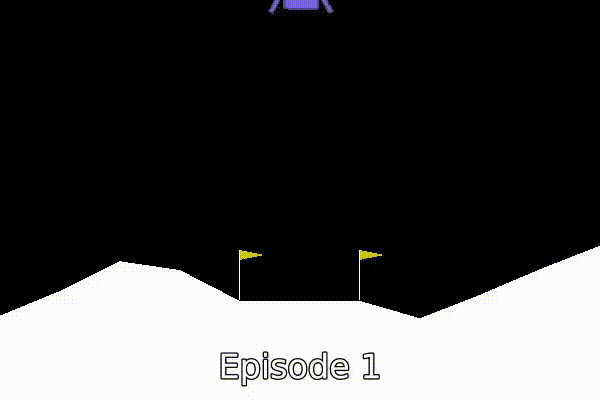

This is an implemention in Pytorch of the final assignment of the excellent [RL specialization](https://www.coursera.org/specializations/reinforcement-learning) offered by Coursera and the Univeristy of Alberta. The original assignment uses an Action-Value-based control method known as Expected SARSA. The 2nd part of this notebook is an attempt at implementing [Policy Gradient Methods](https://lilianweng.github.io/lil-log/2018/04/08/policy-gradient-algorithms.html) to the problem

The environment being tested is the `LunarLander-v2` environment from OpenAIGym's library of environments. The state of the agent includes:
- `x, y` coordinates
- `x, y` velocities
- `angle` of the lander
- angular velocity
- booleans for each leg indicating if leg hit the ground


Excerpts from https://gym.openai.com/envs/LunarLander-v2/ describing the rewards and actions:
- The objective is to land the lander in the landing area, which in the v2 environment is always set at `(0,0)`. 
- Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points.
- Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points.
- Four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.

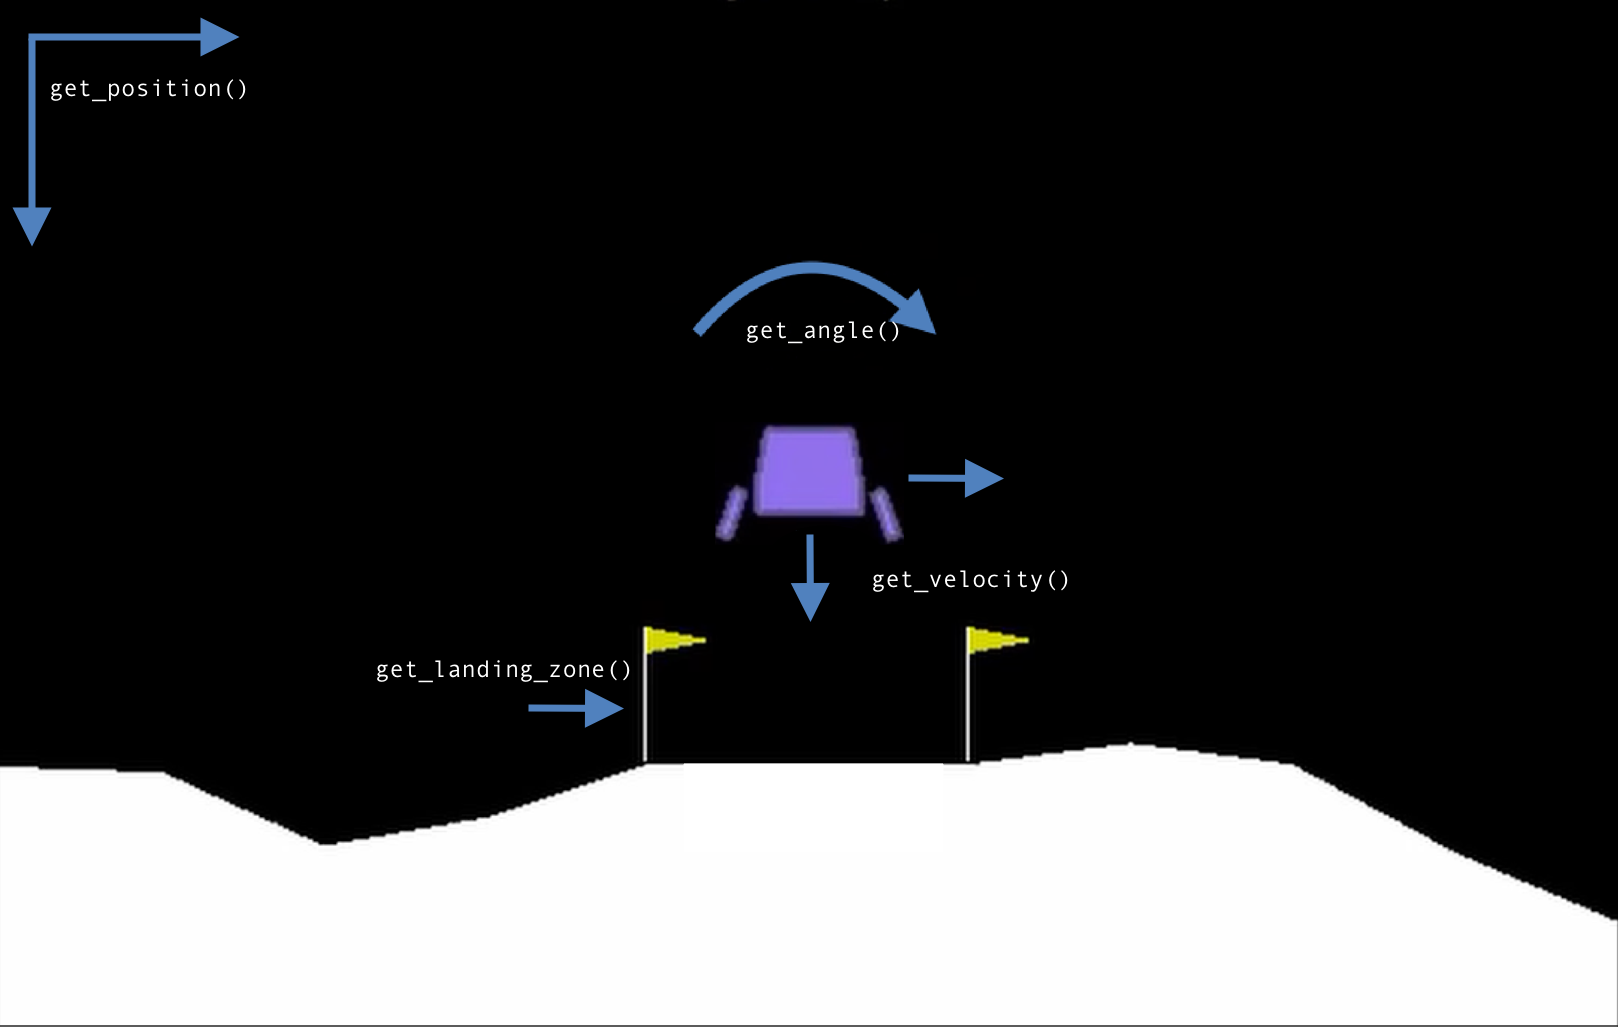


## Introduction

This notebook is split into two main sections. 

### Section 1: On-policy Action Value Method - Expected SARSA
The first section follows the specialization course's capstone assignment closely. This involves implementing an on-policy Action Value control method known as the Expected SARSA algorithm

In the tabular setting this update rule (between timestep `t` and `t+1`) would be:
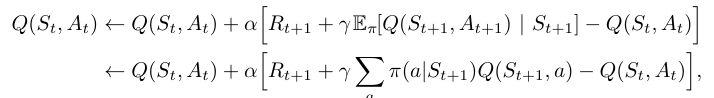

Where $Q(S, A)$ is the action value of state $S$ and action $A$ under a fixed policy $\pi$ and $R$ being the reward of taking action $A$ in that state.  

When using function approximation with neural networks / MLP's, this update becomes:
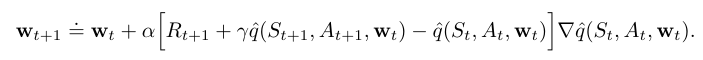

Where $\hat{q}(S, A)$ is the output of the parametric function approximator (a simple feedforward MLP in this case) of the action value at states $S$ and action $A$. $\textbf{w}$ are the parameters of that function approximator.

### Section 2: Policy Gradient Method - Actor Critic
In the next section policy gradient methods are explored. Policy gradient methods are useful to learn the optimal policy directly. 

PG methods are great because they allow one to directly learn the optimal policy without having to worry about many of the problems that plague on-policy methods like exploration. However I see PG methods as neccessary for 2 main reasons:
- Learning an optimal policy that is stochastic is impossible with action-value methods, and a parametrized policy needs to be learned directly (think games with partial information like poker).
- The policy improvement theorem that underlines action value methods' success in the tabular setting no longer holds in the approximate setting, neccessitating learning the policy directly.

PG methods essentially try to maximize some scalar performance measure `J` with respect to the policy parameter `theta`:
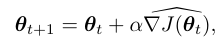

The policy gradient theorem gives us an elegant expression of the policy gradient in terms of state distributions `\mu(s)`, the action value function `q` and the gradient of the policy parameters w.r.t the policy function `\pi`:

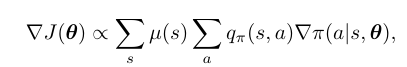

Here we employ the Actor Critic Model, which uses temporal difference technique (bootstrapping the state value) to approximate this gradient:

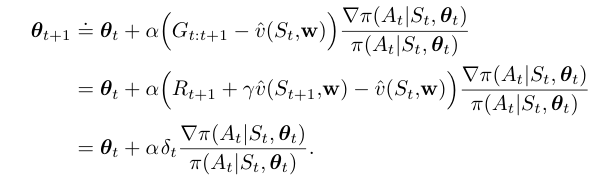

with discounting (which is used in this project to encourage to lander to land as quickly as possible), one actually has to multiply the r.h.s by `\gamma^t`. Besides that one also has to perform an update of the state-value network:

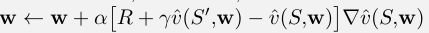

In [9]:
from abc import abstractmethod

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from rl_glue import RLGlue
from environment import BaseEnvironment
from lunar_lander import LunarLanderEnvironment
from agent import BaseAgent
from replay_buffer_agent import ReplayBuffer, ReplayBufferAgent
from collections import deque
from copy import deepcopy
from tqdm import tqdm
import os 
import shutil
from plot_script import plot_result

import torch
from torch import nn

## Section 1: On-policy Action Value Method - Expected SARSA

### Action-Value Network
As one familiar with Action Value Methods may know, we need a function to estimate the action value `q(s,a)` of taking an action `a` at a state `s`. This is approximated as a 2-layer MLP implemented in the `ActionValueNetwork` class. The input to the MLP is the state vector, and the output is the estimated action values for each action (a vector of size `num_actions`). 

Given states-action pairs `(s, a)` encountered during an episode, and the rewards, `get_VE_error` returns the differentiable VE loss, which, when the `backward()` is called, gives exactly the expected SARSA update (without the step size term `alpha`)

### Adam Optimizer
The (Adam optimizer)[https://arxiv.org/abs/1412.6980] is a popular choice in many modern Machine Learning systems, and is used to compute the step size `alpha` and apply the gradients. Adam combines the best of adaptive stepsizes and momentum methods - ideal for nonstationary objectives and problems with noisy / sparse gradients.

### Softmax Policy
Since we only have an Action-Value Network, and no policy function, we'll have to opt for a polic based on action values. A greedy policy is one possibility, but stifles exploration. Epsilon-greedy doesn't consider individual action values when exploring, and so wastes precious samples. A softmax-policy thereforre seems more ideal in this situation, since the exploration can be done more intelligently by choosing only the more promising actions.

The probability of selecting each action according to the softmax policy is shown below:
$$Pr{(A_t=a | S_t=s)} \hspace{0.1cm} \dot{=} \hspace{0.1cm} \frac{e^{Q(s, a)/\tau - max_{c}Q(s, c)/\tau}}{\sum_{b \in A}e^{Q(s, b)/\tau - max_{c}Q(s, c)/\tau}}$$
Which is a softmax with a temperature parameter parameter $\tau$, that controls exploration. The smaller $\tau$ is, the closer the softmax policy approaches a deterministic, greedy one.

### Experience Replay Buffers
An experience replay buffer is an implementation of a simple environment model, which seeks to implement a model simulating the environment transitions using sampled experience, to perform planning using simulated experience produced by this model:
$$p(s', r|s, a)$$
These models are used in model-based approaches, famous techniques include Monte-Carlo Tree Search. Here we simply use experience replay to implement this model. This works because the data represents actual transitions from the underlying MDP (the next state and reward, given the current state).

This kind of model that is not learned and simply a collection of experience can be called non-parametric as it can be ever-growing as opposed to a parametric model where the transitions are learned to be represented with a fixed set of parameters or weights.

It is also worth noting that the actions stored in the experience replay buffer, is produced by policies that change over time, so sampling older experiences, we may be computing the expectation part of the Expected SARSA update w.r.t a stale policy. This doesn't seem to be much of a problem in the Expected SARSA setting, but is much more significant in the PG setting.

The `append()` method adds an experience transition to the buffer as an array that includes the state, action, reward, terminal flag (indicating termination of the episode), and next_state. `sample()` gets a batch of experiences from the buffer with size `minibatch_size`.

### The Learning Loop

`ESARSAAgent` which is a subclass of `ReplayBufferAgent` implements the following learning step (within a larger outer loop over real experiences), using the above components. In the inner loop, we iterate over simulated experiences from the replay buffer

$$
\begin{align}
& \hat{q}_t \leftarrow \text{action-value network at timestep t (current action-value network)}\\
& \text{Initialize } \hat{q}_{t+1}^1 \leftarrow \hat{q}_t\\
& \text{For } i \text{ in } [1, ..., N] \text{ (i.e. N} \text{  replay steps)}:\\
& \hspace{1cm} s, a, r, t, s'
\leftarrow \text{Sample batch of experiences from experience replay buffer} \\
& \hspace{1cm} \text{Do Expected Sarsa update with } \hat{q}_t: \hat{q}_{t+1}^{i+1}(s, a) \leftarrow \hat{q}_{t+1}^{i}(s, a) + \alpha \cdot \left[r + \gamma \left(\sum_{b} \pi(b | s') \hat{q}_t(s', b)\right) - \hat{q}_{t+1}^{i}(s, a)\right]\\
& \hspace{1.5cm} \text{ making sure to add the } \gamma \left(\sum_{b} \pi(b | s') \hat{q}_t(s', b)\right) \text{ for non-terminal transitions only.} \\
& \text{After N replay steps, we set } \hat{q}_{t+1}^{N} \text{ as } \hat{q}_{t+1} \text{ and have a new } \hat{q}_{t+1} \text{for time step } t + 1 \text{ that we will fix in the next set of updates. }
\end{align}
$$

In [10]:
class ActionValueNetwork:
    def __init__(self, network_config):
        self.state_dim = network_config.get("state_dim")
        self.num_hidden_units = network_config.get("num_hidden_units")
        self.num_actions = network_config.get("num_actions")
        
        self.rand_generator = np.random.RandomState(network_config.get("seed"))
        
        self.layer_sizes = [self.state_dim, self.num_hidden_units, self.num_actions]
        num_layers = len(self.layer_sizes) - 1
        model_layers = []
        for i in range(0, num_layers):
            model_layers.append(nn.Linear(self.layer_sizes[i], self.layer_sizes[i + 1]))
            with torch.no_grad():
                model_layers[-1].weight[:, :] = torch.Tensor(self._init_saxe(self.layer_sizes[i], self.layer_sizes[i + 1])).T
                model_layers[-1].bias[:] = torch.zeros(1, self.layer_sizes[i + 1])
            if i < num_layers - 1:
                model_layers.append(nn.ReLU())
        
        self.model = nn.Sequential(*model_layers)
        self.loss = nn.MSELoss()
        
    
    def get_action_values(self, s):
        """
        Args:
            s (tensor): The state.
        Returns:
            The action-values (Numpy array) calculated using the network's weights.
        """
        return self.model(s)
    
    def get_VE_error(self, s, target, actions_taken):
        """
        Args:
            s (tensor): The state.
            target (tensor): Target return (R + gamma sum_a' q(s', a', w) for expected sarsa) 
            actions_taken (tensor)
        Returns:
            The VE error tensor 0.5*(qhat(s,a) - target)^2
        """
    
        # given the actions taken, compute qhat(a)
        batch_size = s.shape[0]
        qhat = self.get_action_values(s)
        action_indicator = torch.zeros(batch_size, self.num_actions, dtype=torch.float)
        action_indicator[torch.arange(batch_size), actions_taken.long()] = 1.
        qhat_a = torch.sum(torch.multiply(qhat, action_indicator), dim=1)
        # compute the error between the target and qhat(a)
        err = self.loss(qhat_a, target) / 2.
                
        return err
    
    # (Exact solutions to the nonlinear dynamics of learning in deep linear neural networks by Saxe, A et al., 2013)
    def _init_saxe(self, rows, cols):
        """
        Args:
            rows (int): number of input units for layer.
            cols (int): number of output units for layer.
        Returns:
            NumPy Array consisting of weights for the layer based on the initialization in Saxe et al.
        """
        tensor = self.rand_generator.normal(0, 1, (rows, cols))
        if rows < cols:
            tensor = tensor.T
        tensor, r = np.linalg.qr(tensor)
        d = np.diag(r, 0)
        ph = np.sign(d)
        tensor *= ph

        if rows < cols:
            tensor = tensor.T
        return tensor

    def set_weights(self, weights):
        """
        weights is list of dicts, each element in the list is a layer,
        the dict has keys 'W' and 'b' for each linear layer
        """
        for l, layer_weight in enumerate(weights):
            with torch.no_grad():
                # assumes we always have a relu between the linears
                self.model[l*2].weight[:, :] = torch.Tensor(layer_weight['W']).T
                self.model[l*2].bias[:] = torch.Tensor(layer_weight['b'])

In [11]:
# Tests for the action value network and methods
network_config = {
    "state_dim": 5,
    "num_hidden_units": 20,
    "num_actions": 3,
    "seed": 40
}

test_network = ActionValueNetwork(network_config)
s = torch.Tensor(np.random.uniform(size=(10, test_network.state_dim)))
target = torch.Tensor(np.random.uniform(size=(10,)))
actions_taken = torch.Tensor(np.random.randint(0, test_network.num_actions, size=(10,)))
err = test_network.get_VE_error(s, target, actions_taken)

softmax with temperature tau

In [12]:
def softmax(action_values, tau=1.0):
    """
    Args:
        action_values (tensor): A 2D tensor of shape (batch_size, num_actions). 
                       The action-values computed by an action-value network.              
        tau (float): The temperature parameter scalar.
    Returns:
        A 2D tensor of shape (batch_size, num_actions). Where each column is a probability distribution over
        the actions representing the policy.
    """
    
    # Compute the preferences by dividing the action-values by the temperature parameter tau
    preferences = action_values / tau
    # Compute the maximum preference across the actions, and subtract
    max_preference = torch.max(preferences, dim=1, keepdim=True)[0] # (b, 1)
    exp_preferences = torch.exp(preferences - max_preference) # (b, a)
    # denominator
    sum_of_exp_preferences = torch.sum(exp_preferences, dim=1)  #(b, )
    sum_of_exp_preferences = torch.unsqueeze(sum_of_exp_preferences, dim=1)  #(b, 1)
    # Compute the action probabilities
    action_probs = exp_preferences / sum_of_exp_preferences #(b, a)
    
    # squeeze() removes any singleton dimensions. It is used here because this function is used in the 
    # agent policy when selecting an action (for which the batch dimension is 1.) As np.random.choice is used in 
    # the agent policy and it expects 1D arrays, we need to remove this singleton batch dimension.
    action_probs = torch.squeeze(action_probs)
    return action_probs

`get_target_vec` Computes the (bootstrapped) target vector, where $\pi$ and $\hat{q}$ are computed using a network that is fixed for every iteration of the inner loop

$R_t + \gamma \mathbb{E}_{\pi} [\pi(a|S_{t+1}) \hat{q}(S_{t+1}, a)]$

In [13]:
def get_target_vec(states, next_states, rewards, discount, terminals, current_q, tau):
    """
    Args:
        states (tensor): The batch of states with the shape (batch_size, state_dim).
        next_states (tensor): The batch of next states with the shape (batch_size, state_dim).
        rewards (tensor): The batch of rewards with the shape (batch_size,).
        discount (float): The discount factor.
        terminals (tensor): The batch of terminals with the shape (batch_size,).
        current_q (ActionValueNetwork): The fixed network used for computing the targets, 
                                        and particularly, the action-values at the next-states.
    Returns:
        The target vector (tensor) R_{t} + gamma * v_{t+1}
    """    
    # Compute action values at next states using current_q network    
    # don't want to propagate gradients through target in semi-grad methods
    q_next_mat = current_q.get_action_values(next_states).detach()
    # Compute policy at next state by passing the action-values in q_next_mat to softmax()
    probs_mat = softmax(q_next_mat, tau=tau)
    
    # Compute the estimate of the next state value, v_next_vec, using the expected SARSA update
    # (1 - terminals) to make sure v_next_vec is zero for terminal next states.
    v_next_vec = torch.sum(probs_mat * q_next_mat, dim=1) * (1 - terminals)
    
    # Compute Expected Sarsa target
    # Note that target_vec is a 1D array of shape (batch_size,)
    target_vec = rewards + discount * v_next_vec
    
    return target_vec

`optimize_network` implements one step within the inner loop of the algorithm

In [14]:
def optimize_network(experiences, discount, optimizer, network, current_q, tau, has_timestep=False):
    """
    Args:
        experiences (Numpy array): The batch of experiences including the states, actions, 
                                   rewards, terminals, and next_states.
        discount (float): The discount factor.
        network (ActionValueNetwork): The latest state of the network that is getting replay updates.
        current_q (ActionValueNetwork): The fixed network used for computing the targets, 
                                        and particularly, the action-values at the next-states.
    """
    optimizer.zero_grad()
    
    # Get states, action, rewards, terminals, and next_states from experiences
    if has_timestep:
        states, actions, rewards, terminals, next_states, _ = map(list, zip(*experiences))
    else:
        states, actions, rewards, terminals, next_states = map(list, zip(*experiences))
    states = torch.Tensor(np.concatenate(states))
    next_states = torch.Tensor(np.concatenate(next_states))
    rewards = torch.Tensor(rewards)
    terminals = torch.Tensor(terminals)
    actions = torch.Tensor(actions)
    batch_size = states.shape[0]


    # Compute target vector, get error, backward, update
    target_vec = get_target_vec(states, next_states, rewards, discount, terminals, current_q, tau)
    VE_error = network.get_VE_error(states, target_vec, actions)
    VE_error.backward()
    optimizer.step()

In [15]:
# Run optimize_network tests against some reference input / output

input_data = np.load("asserts/optimize_network_input_1.npz", allow_pickle=True)

experiences = list(input_data["experiences"])
discount = float(input_data["discount"])
tau = 0.001

network_config = {"state_dim": 8,
                  "num_hidden_units": 512,
                  "num_actions": 4
                  }

network = ActionValueNetwork(network_config)
network.set_weights(input_data["network_weights"])

current_q = ActionValueNetwork(network_config)
current_q.set_weights(input_data["current_q_weights"])

states, actions, rewards, terminals, next_states = map(list, zip(*experiences))
states = torch.Tensor(np.concatenate(states))
next_states = torch.Tensor(np.concatenate(next_states))
rewards = torch.Tensor(rewards)
terminals = torch.Tensor(terminals)
actions = torch.Tensor(actions)
batch_size = states.shape[0]

target_vec = get_target_vec(states, next_states, rewards, discount, terminals, current_q, tau)
VE_error = network.get_VE_error(states, target_vec, actions)
VE_error.backward()

answer_td_update = np.load("asserts/optimize_network_td_update_ref.npz", allow_pickle=True)["td_update"]

for l, layer in enumerate(network.model[::2]):
    assert np.allclose(-layer.weight.grad.numpy(), answer_td_update[l]['W'].T)
    assert np.allclose(-layer.bias.grad.numpy(), answer_td_update[l]['b'][0])

optimizer_config = {'step_size': 3e-5, 
                    'beta_m': 0.9, 
                    'beta_v': 0.999,
                    'epsilon': 1e-8
                   }
from torch.optim import Adam
optimizer = Adam(
    network.model.parameters(), 
    lr=optimizer_config['step_size'], 
    betas=(optimizer_config['beta_m'], optimizer_config['beta_v']),
    eps=optimizer_config['epsilon']
)
optimize_network(experiences, discount, optimizer, network, current_q, tau)

answer_updated_weights = np.load("asserts/optimize_network_updated_weights_ref.npz", allow_pickle=True)["updated_weights"]
for l, layer in enumerate(network.model[::2]):
    assert np.allclose(layer.weight.detach().numpy(), answer_updated_weights[l]['W'].T)
    assert np.allclose(layer.bias.detach().numpy(), answer_updated_weights[l]['b'][0])

The Agent implementation - `ESARSAAgent` is a subclass of the `ReplayBufferAgent` which runs an outer and inner loop using real and simulate experiences respectively. Each step taken within the inner loop is implemented in the `agent_step` method

In [16]:
class ESARSAAgent(ReplayBufferAgent):
    def __init__(self):
        self.name = "expected_sarsa_agent"
        
    def _agent_init(self, agent_config):
        """Setup for the agent called when the experiment first starts.

        Set parameters needed to setup the agent.

        Assume agent_config dict contains:
        {
            network_config: dictionary,
            optimizer_config: dictionary,
            replay_buffer_size: integer,
            minibatch_sz: integer, 
            num_replay_updates_per_step: float
            discount_factor: float,
        }
        """
        # initialize q-network
        self.network = ActionValueNetwork(agent_config['network_config'])
        # initialize optimizer
        optimizer_config = agent_config['optimizer_config']
        self.optimizer = Adam(
            self.network.model.parameters(), 
            lr=optimizer_config['step_size'], 
            betas=(optimizer_config['beta_m'], optimizer_config['beta_v']),
            eps=optimizer_config['epsilon']
        )
        self.num_actions = agent_config['network_config']['num_actions']
        self.discount = agent_config['gamma']
        self.tau = agent_config['tau']
        
        self.rand_generator = np.random.RandomState(agent_config.get("seed"))

    # Work Required: No.
    def policy(self, state):
        """
        Args:
            state (Numpy array): the state.
        Returns:
            the action. 
        """
        action_values = self.network.get_action_values(torch.Tensor(state))
        probs_batch = softmax(action_values, self.tau).detach().numpy()
        action = self.rand_generator.choice(self.num_actions, p=probs_batch.squeeze())
        return action

    def agent_optimize(self, experiences):
        optimize_network(experiences, self.discount, self.optimizer, self.network, self.current_q, self.tau, has_timestep=True)
    
    def agent_pre_replay(self):
        self.current_q = deepcopy(self.network)
    
    def agent_post_replay(self):
        pass

    def agent_message(self, message):
        if message == "get_sum_reward":
            return self.sum_rewards
        elif message == "set_train_mode":
            self.train = True
        elif message == "set_eval_mode":
            self.train = False
        else:
            raise Exception("Unrecognized Message!")

In [ ]:
# Run agent tests against some reference input / output
agent_info = {
             'network_config': {
                 'state_dim': 8,
                 'num_hidden_units': 256,
                 'num_hidden_layers': 1,
                 'num_actions': 4
             },
             'optimizer_config': {
                 'step_size': 3e-5, 
                 'beta_m': 0.9, 
                 'beta_v': 0.999,
                 'epsilon': 1e-8
             },
             'replay_buffer_size': 32,
             'minibatch_sz': 32,
             'num_replay_updates_per_step': 4,
             'gamma': 0.99,
             'tau': 1000.0,
             'seed': 0}

# Initialize agent
agent = ESARSAAgent()
agent.agent_init(agent_info)

# load agent network, optimizer, replay_buffer from the agent_input_1.npz file
input_data = np.load("asserts/agent_input_1.npz", allow_pickle=True)
agent.network.set_weights(input_data["network_weights"])
agent.replay_buffer.rand_generator.seed(int(input_data["replay_buffer_seed"]))
for experience in input_data["replay_buffer"]:
    agent.replay_buffer.buffer.append(experience)

# Perform agent_step multiple times
last_state_array = input_data["last_state_array"]
last_action_array = input_data["last_action_array"]
state_array = input_data["state_array"]
reward_array = input_data["reward_array"]

for i in range(5):
    agent.last_state = last_state_array[i]
    agent.last_action = last_action_array[i]
    state = state_array[i]
    reward = reward_array[i]
    
    agent.agent_step(reward, state)
    
    # compare state and actions
    output_data = np.load("asserts/agent_step_output_ref_{}.npz".format(i), allow_pickle=True)
    np.allclose(agent.last_state, output_data["last_state"])
    np.allclose(agent.last_action, output_data["last_action"])
    
    # compare updated weights
    answer_updated_weights = output_data["updated_weights"]
    for l, layer in enumerate(agent.network.model[::2]):
        assert np.allclose(layer.weight.detach().numpy(), answer_updated_weights[l]['W'].T)
        assert np.allclose(layer.bias.detach().numpy(), answer_updated_weights[l]['b'][0])
    
    # compare replay buffer
    answer_replay_buffer = output_data["replay_buffer"]
    for i in range(answer_replay_buffer.shape[0]):
        for j in range(answer_replay_buffer.shape[1]):
            assert(np.allclose(np.asarray(agent.replay_buffer.buffer)[i][j], answer_replay_buffer[i, j]))

In [18]:
def run_experiment(environment, agent, environment_parameters, agent_parameters, experiment_parameters):
    
    rl_glue = RLGlue(environment, agent)
        
    # save sum of reward at the end of each episode
    agent_sum_reward = np.zeros((experiment_parameters["num_runs"], 
                                 experiment_parameters["num_episodes"]))

    env_info = environment_parameters

    agent_info = agent_parameters
    num_episodes = experiment_parameters["num_episodes"]
    num_ckpts = experiment_parameters.get('num_checkpoints', 1)
    ckpt_every = int(np.round(num_episodes / num_ckpts))

    # one agent setting
    for run in range(1, experiment_parameters["num_runs"]+1):
        agent_info["seed"] = run
        agent_info["network_config"]["seed"] = run
        env_info["seed"] = run

        rl_glue.rl_init(agent_info, env_info)
        
        for episode in tqdm(range(1, num_episodes+1)):
            # run episode
            rl_glue.rl_episode(experiment_parameters["timeout"])
            
            episode_reward = rl_glue.rl_agent_message("get_sum_reward")
            agent_sum_reward[run - 1, episode - 1] = episode_reward

        # record one final episode in eval mode
        rl_glue.rl_agent_message("set_eval_mode")
        rl_glue.rl_episode(experiment_parameters["timeout"])
        rl_glue.rl_agent_message("set_train_mode")
        rl_glue.rl_cleanup()

    save_name = "{}".format(rl_glue.agent.name)
    if not os.path.exists('results'):
        os.makedirs('results')
    np.save("results/sum_reward_{}".format(save_name), agent_sum_reward)
    shutil.make_archive('results', 'zip', 'results')

## Running the experiment

The following parameters were directly copied from the original assignment.

As can be seen, the average reward of an episode approaches 100, which is near the theoretical limit fo what is attainable. From the trendline, it looks like it could approach that limit even more closely

In [11]:
# Run Experiment

# Experiment parameters
experiment_parameters = {
    "num_runs" : 1,
    "num_episodes" : 300,
    # OpenAI Gym environments allow for a timestep limit timeout, causing episodes to end after 
    # some number of timesteps. Here we use the default of 500.
    "timeout" : 500
}

# Environment parameters
environment_parameters = {
    "num_episodes": experiment_parameters["num_episodes"],
    "timeout": experiment_parameters["timeout"],
}

current_env = LunarLanderEnvironment

# Agent parameters
agent_parameters = {
    'network_config': {
        'state_dim': 8,
        'num_hidden_units': 256,
        'num_actions': 4
    },
    'optimizer_config': {
        'step_size': 1e-3,
        'beta_m': 0.9, 
        'beta_v': 0.999,
        'epsilon': 1e-8
    },
    'replay_buffer_size': 50000,
    'minibatch_sz': 8,
    'num_replay_updates_per_step': 4,
    'gamma': 0.99,
    'tau': 0.001
}
current_agent = ESARSAAgent

# run experiment
run_experiment(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters)

100%|██████████| 300/300 [10:46<00:00,  2.15s/it]


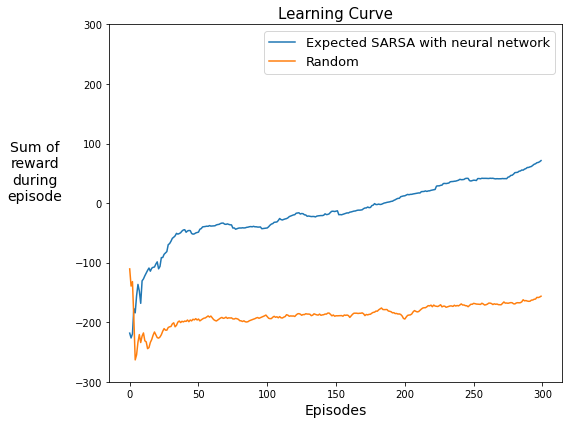

In [11]:
plot_result([
    {
        "data_path": "results/sum_reward_expected_sarsa_agent.npy", 
        "data_legend": "Expected SARSA with neural network"
    }, 
    {
        "data_path": "results/sum_reward_random_agent.npy", 
        "data_legend": "Random"
    }
])

## Section 2: Policy Gradients with Actor-Critic

The Actor-Critic Policy Gradient update:

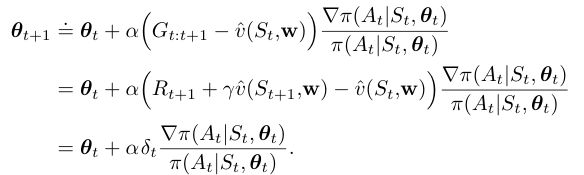

### Policy Network

This is the **actor** part of Actor-Critic
Since we now model the policy directly, we require a policy network $\pi(A|S)$. The architecture is identical to that of the actio-value network in section 1, and is a 2-layer MLP implemented in the `PolicyNetwork` class. Input is the state vector, output is the estimated action *preferences* over each action given the state. Softmax the action preferences to get actual probabilities.

The eligibility vector $\nabla \pi(s|a) / \pi(s|a) = \nabla \ln(\pi(s|a)) $ is calculated by the `get_eligibility_loss` method, implemented as a Cross-Entropy Loss between the action preferences and the actions taken.

### State-Value Network

The **critic** or state-value network evaluates the state value of the the current state and provides a multipler to the gradient in the form of the TD error $\delta_t$. Here the critic network is implemented as an MLP with a single scalar - the state value - as an output.

The loss used for the state value network is similar to that of the action value network - MSE on a 1-step TD target, giving the following update:


As before, `get_VE_error` returns the differentiable VE loss, which, when the `backward()` is called, gives exactly the expected SARSA update (without the step size term `alpha`)

### Adam Optimizer

The chosen optimizer algorithm is the same as that used in the Expected SARSA setting, however, a choice has to be made here for the step sizes of the state-value and policy network $\alpha_{\boldsymbol{\theta}}$ and $\alpha_{\textbf{w}}$. A ratio of $1:50$ was observed to be ideal. The policy network should always be slower to evolve than the state value, otherwise, the state value network (and hence the gradient) will not be able to keep up with the policy.

### Experience Replay

These are used in exactly the same way as in the Expected SARSA setting. However, as noted in Section 1, the buffer will contain experiences that are from a stale policy. Using the same sized experience buffer as in Section 1 made convergence for both the state-value and policy networks very difficult to achieve. Reducing the size from `5e05` to `1e03` helped significantly.

### Learning Loop

`ACAgent`, like `ESARSAAgent` is a subclass of `ReplayBufferAgent` implements the following learning step (within a larger outer loop over real experiences), using the above components. In the inner loop, we iterate over simulated experiences from the replay buffer

$$
\begin{align}
& \hat{v}_t \leftarrow \text{state-value network at timestep t (current action-value network)}\\
& \pi_t \leftarrow \text{policy network at timestep t (current action-value network)}\\
& \text{Initialize } \hat{v}_{t+1}^1 \leftarrow \hat{v}_t\\
& \text{Initialize } \pi_{t+1}^1 \leftarrow \pi_t\\
& \text{For } i \text{ in } [1, ..., N] \text{ (i.e. N} \text{  replay steps)}:\\
& \hspace{1cm} s, a, r, t, s'
\leftarrow \text{Sample batch of experiences from experience replay buffer} \\
& \hspace{1cm} \delta \leftarrow r + \gamma \hat{v}_{t+1}^i(s, \textbf{w}) - \gamma \hat{v}_{t}(s, \textbf{w}) \\
& \hspace{1cm} \text{Update state-value network } \textbf{w}_{t+1}^{i+1} \leftarrow \textbf{w}_{t+1}^i + \alpha_{\textbf{w}} \delta \nabla \hat{v}_{t+1}^i(s, \textbf{w})\\
& \hspace{1cm} \text{Update policy network } \boldsymbol{\theta}_{t+1}^{i+1} \leftarrow \boldsymbol{\theta}_{t+1}^i + \alpha_{\boldsymbol{\theta}} \gamma^{t} \delta \nabla \pi_{t+1}^i(a|s, \boldsymbol{\theta})\\
& \hspace{1.5cm} \text{ making sure to add the } \gamma \hat{v}_{t}(s) \text{ for non-terminal transitions only.} \\
& \text{After N replay steps, we set } \hat{v}_{t+1}^{N} \text{ as } \hat{v}_{t+1} \text{ and set } \pi_{t+1}^{N} \text{ as } \pi_{t+1}
\end{align}
$$

In [19]:
class PolicyNetwork:
    def __init__(self, network_config):
        self.state_dim = network_config.get("state_dim")
        self.num_hidden_units = network_config.get("num_hidden_units")
        self.num_actions = network_config.get("num_actions")
        
        self.rand_generator = np.random.RandomState(network_config.get("seed"))
        
        self.layer_sizes = [self.state_dim, self.num_hidden_units, self.num_actions]
        num_layers = len(self.layer_sizes) - 1
        model_layers = []
        for i in range(0, num_layers):
            model_layers.append(nn.Linear(self.layer_sizes[i], self.layer_sizes[i + 1]))
            with torch.no_grad():
                model_layers[-1].weight[:, :] = torch.Tensor(self._init_saxe(self.layer_sizes[i], self.layer_sizes[i + 1])).T
                model_layers[-1].bias[:] = torch.zeros(1, self.layer_sizes[i + 1])
            if i < num_layers - 1:
                model_layers.append(nn.ReLU())
        
        self.model = nn.Sequential(*model_layers)
        self.loss = nn.CrossEntropyLoss(reduction='none')
        
    def get_action_pref(self, s):
        """
        Args:
            s (tensor): The state.
        Returns:
            The action-preference (tensor)
        """
        return self.model(s)
    
    def get_eligibility_loss(self, s, actions_taken):
        """
        Args:
            s (tensor): The state.
            actions_taken (tensor)
        Returns:
            The eligibility loss component of the policy gradient (log(A|S))
        """
    
        # given the actions taken, compute qhat(a)
        h_sa = self.get_action_pref(s)
        # compute the error between the target and qhat(a)
        eligibility_loss = self.loss(h_sa, actions_taken)
                
        return eligibility_loss
    
    # (Exact solutions to the nonlinear dynamics of learning in deep linear neural networks by Saxe, A et al., 2013)
    def _init_saxe(self, rows, cols):
        """
        Args:
            rows (int): number of input units for layer.
            cols (int): number of output units for layer.
        Returns:
            NumPy Array consisting of weights for the layer based on the initialization in Saxe et al.
        """
        tensor = self.rand_generator.normal(0, 1, (rows, cols))
        if rows < cols:
            tensor = tensor.T
        tensor, r = np.linalg.qr(tensor)
        d = np.diag(r, 0)
        ph = np.sign(d)
        tensor *= ph

        if rows < cols:
            tensor = tensor.T
        return tensor

    def set_weights(self, weights):
        """
        weights is list of dicts, each element in the list is a layer,
        the dict has keys 'W' and 'b' for each linear layer
        """
        for l, layer_weight in enumerate(weights):
            with torch.no_grad():
                # assumes we always have a relu between the linears
                self.model[l*2].weight[:, :] = torch.Tensor(layer_weight['W']).T
                self.model[l*2].bias[:] = torch.Tensor(layer_weight['b'])

Testing the policy network

In [20]:
network_config = {
    "state_dim": 5,
    "num_hidden_units": 20,
    "num_actions": 3,
    "seed": 40
}

test_network = PolicyNetwork(network_config)
s = torch.Tensor(np.random.uniform(size=(10, test_network.state_dim)))
target = torch.Tensor(np.random.uniform(size=(10,)))
actions_taken = torch.LongTensor(np.random.randint(0, test_network.num_actions, size=(10,)))
err = test_network.get_eligibility_loss(s, actions_taken)

In [21]:
class StateValueNetwork:
    def __init__(self, network_config):
        self.state_dim = network_config.get("state_dim")
        self.num_hidden_units = network_config.get("num_hidden_units")
        
        self.rand_generator = np.random.RandomState(network_config.get("seed"))
        
        self.layer_sizes = [self.state_dim, self.num_hidden_units, 1]
        num_layers = len(self.layer_sizes) - 1
        model_layers = []
        for i in range(0, num_layers):
            model_layers.append(nn.Linear(self.layer_sizes[i], self.layer_sizes[i + 1]))
            with torch.no_grad():
                model_layers[-1].weight[:, :] = torch.Tensor(self._init_saxe(self.layer_sizes[i], self.layer_sizes[i + 1])).T
                model_layers[-1].bias[:] = torch.zeros(1, self.layer_sizes[i + 1])
            if i < num_layers - 1:
                model_layers.append(nn.ReLU())
        
        self.model = nn.Sequential(*model_layers)
        self.loss = nn.MSELoss()
        
    
    def get_state_values(self, s):
        """
        Args:
            s (tensor): The state.
        Returns:
            The state-values (tensor)
        """
        return self.model(s)[:, 0]
    
    def get_VE_error(self, s, target):
        """
        Args:
            s (tensor): The state.
            target (tensor): Target return (R + gamma v(s', w) for expected sarsa) 
        Returns:
            The VE error 0.5 * (vhat - target) ^ 2
        """
    
        # given the actions taken, compute qhat(a)
        vhat = self.get_state_values(s)
        # compute the error between the target and qhat(a)
        err = self.loss(vhat, target) / 2.
                
        return err
    
    # (Exact solutions to the nonlinear dynamics of learning in deep linear neural networks by Saxe, A et al., 2013)
    def _init_saxe(self, rows, cols):
        """
        Args:
            rows (int): number of input units for layer.
            cols (int): number of output units for layer.
        Returns:
            NumPy Array consisting of weights for the layer based on the initialization in Saxe et al.
        """
        tensor = self.rand_generator.normal(0, 1, (rows, cols))
        if rows < cols:
            tensor = tensor.T
        tensor, r = np.linalg.qr(tensor)
        d = np.diag(r, 0)
        ph = np.sign(d)
        tensor *= ph

        if rows < cols:
            tensor = tensor.T
        return tensor

    def set_weights(self, weights):
        """
        weights is list of dicts, each element in the list is a layer,
        the dict has keys 'W' and 'b' for each linear layer
        """
        for l, layer_weight in enumerate(weights):
            with torch.no_grad():
                # assumes we always have a relu between the linears
                self.model[l*2].weight[:, :] = torch.Tensor(layer_weight['W']).T
                self.model[l*2].bias[:] = torch.Tensor(layer_weight['b'])

`get_target_vec` Computes the (bootstrapped) target vector, where $\hat{v}$ are computed using a network that is fixed for every iteration of the inner loop

$R_t + \gamma \hat{v}(S_{t+1})$

In [22]:
# TODO: this would be better as a StateValueNetwork method?
def get_target_vec_state_val(states, next_states, rewards, discount, terminals, current_v):
    """
    Compute 1-step TD target state value
    Args:
        states (tensor): The batch of states with the shape (batch_size, state_dim).
        next_states (tensor): The batch of next states with the shape (batch_size, state_dim).
        rewards (tensor): The batch of rewards with the shape (batch_size,).
        discount (float): The discount factor.
        terminals (tensor): The batch of terminals with the shape (batch_size,).
        current_v (StateValueNetwork): The fixed network used for computing the targets, 
                                        and particularly, the action-values at the next-states.
    Returns:
        The target state value (Numpy array) R_{t} + discount * vhat_{t+1}
    """
    # Compute action values at next states using current_v network
    # don't want to propagate gradients through target in semi-grad methods
    v_next_vec = current_v.get_state_values(next_states).detach()
    # (1 - terminals) to make sure v_next_vec is zero for terminal next states.
    v_next_vec = v_next_vec * (1 - terminals)
    # Compute State Value Target
    target_vec = rewards + discount * v_next_vec
    
    return target_vec

Computes the TD error given the output of `get_target_vec` 

$\delta = R_t + \gamma \hat{v}(S_{t+1}) - \hat{v}(S_{t})$

In [23]:
# TODO: this would be better as a StateValueNetwork method?
def get_td_error_state_val(states, actions, network, target_vec):
    """
    Args:
        states (tensor): The batch of states with the shape (batch_size, state_dim).
        actions (tensor): The batch of actions with the shape (batch_size,).
        network (StateValueNetwork): The latest state of the network that is getting replay updates.
        target_vec (StateValueNetwork): reward + gamma * state_val(next_state)
    Returns:
        The TD errors (tensor) for actions taken, of shape (batch_size,)
    """
    v_vec = network.get_state_values(states)
    delta_vec = target_vec - v_vec
    
    return delta_vec

`optimize_network_pg` implements one step within the inner loop of the actor-critic algorithm

In [24]:
def optimize_network_pg(experiences, discount, optimizer, critic, actor, current_v, has_timestep=False):
    """
    Args:
        experiences (Numpy array): The batch of experiences including the states, actions, 
                                   rewards, terminals, and next_states.
        discount (float): The discount factor.
        optimizer (float): The torch optimizer object responsible for network updates.
        critic (StateValueNetwork): The latest state of the critic network that is getting replay updates.
        actor (StateValueNetwork): The latest state of the actor network that is getting replay updates.
        current_v (StateValueNetwork): The fixed network used for computing the targets, 
                                        and particularly, the state-values at the next-states.
    """
    optimizer.zero_grad()
    # Get states, action, rewards, terminals, and next_states from experiences
    if has_timestep:
        states, actions, rewards, terminals, next_states, timesteps = map(list, zip(*experiences))
    else:
        states, actions, rewards, terminals, next_states = map(list, zip(*experiences))
        timesteps = [1] * len(states)
    states = torch.Tensor(np.concatenate(states))
    next_states = torch.Tensor(np.concatenate(next_states))
    rewards = torch.Tensor(rewards)
    terminals = torch.Tensor(terminals)
    actions = torch.LongTensor(actions)
    timesteps = torch.LongTensor(timesteps) - 1
    batch_size = states.shape[0]


    # Compute TD error using the get_td_error function
    # Note that q_vec is a 1D array of shape (batch_size)
    target_vec = get_target_vec_state_val(states, next_states, rewards, discount, terminals, current_v)
    VE_error = critic.get_VE_error(states, target_vec)
    VE_error.backward()
    target_vec_act = get_target_vec_state_val(states, next_states, rewards, discount, terminals, current_v)
    td_error = get_td_error_state_val(states, actions, current_v, target_vec_act)
    policy_loss = torch.mean(
        torch.pow(discount, timesteps) * td_error.detach() * actor.get_eligibility_loss(states, actions)
    )
    policy_loss.backward()

    # Pass network.get_weights and the td_update to the optimizer to get updated weights
    optimizer.step()
    return torch.mean(VE_error).detach().item()

In [28]:
# testing the optimize_network_pg method

input_data = np.load("asserts/optimize_network_input_1.npz", allow_pickle=True)

experiences = list(input_data["experiences"])
discount = float(input_data["discount"])
tau = 0.001

network_config = {"state_dim": 8,
                  "num_hidden_units": 512,
                  "num_actions": 4
                  }

critic = StateValueNetwork(network_config)

actor = PolicyNetwork(network_config)

current_v = StateValueNetwork(network_config)

states, actions, rewards, terminals, next_states = map(list, zip(*experiences))
states = torch.Tensor(np.concatenate(states))
next_states = torch.Tensor(np.concatenate(next_states))
rewards = torch.Tensor(rewards)
terminals = torch.Tensor(terminals)
actions = torch.Tensor(actions)
batch_size = states.shape[0]

optimizer_config = {'step_size': 3e-5, 
                    'beta_m': 0.9, 
                    'beta_v': 0.999,
                    'epsilon': 1e-8
                   }
from torch.optim import Adam
optimizer = Adam(
    [{'params': actor.model.parameters()}, {'params': critic.model.parameters()}], 
    lr=optimizer_config['step_size'], 
    betas=(optimizer_config['beta_m'], optimizer_config['beta_v']),
    eps=optimizer_config['epsilon']
)
optimize_network_pg(experiences, discount, optimizer, critic, actor, current_v)

0.010155861265957355

The Agent implementation - `ACAgent` is a subclass of the `ReplayBufferAgent` which runs an outer and inner loop using real and simulate experiences respectively. Each step taken within the inner loop is implemented in the `agent_step` method

In [26]:
class ACAgent(ReplayBufferAgent):
    def __init__(self):
        self.name = "actor_critic_agent"
        
    def _agent_init(self, agent_config):
        """Setup for the agent called when the experiment first starts.

        Set parameters needed to setup the agent.

        Assume agent_config dict contains:
        {
            network_config: dictionary,
            optimizer_config: dictionary,
            replay_buffer_size: integer,
            minibatch_sz: integer, 
            num_replay_updates_per_step: float
            discount_factor: float,
        }
        """
        # initialize q-network
        self.critic = StateValueNetwork(network_config)
        self.actor = PolicyNetwork(network_config)
        # initialize optimizer
        optimizer_config = agent_config['optimizer_config']
        self.optimizer = Adam(
            [
                {'params': self.actor.model.parameters(), 'lr': optimizer_config['step_size'] / 50.}, 
                {'params': self.critic.model.parameters(), 'lr': optimizer_config['step_size']}
            ], 
            betas=(optimizer_config['beta_m'], optimizer_config['beta_v']),
            eps=optimizer_config['epsilon']
        )
        self.num_actions = agent_config['network_config']['num_actions']
        self.discount = agent_config['gamma']
        
        self.rand_generator = np.random.RandomState(agent_config.get("seed"))
        self.sum_ve_error = 0
        
    # Work Required: No.
    def policy(self, state):
        """
        Args:
            state (Numpy array): the state.
        Returns:
            the action. 
        """
        action_pref = self.actor.get_action_pref(torch.Tensor(state))
        probs_batch = softmax(action_pref, 1).detach().numpy()
        action = self.rand_generator.choice(self.num_actions, p=probs_batch.squeeze())
        return action
    
    def agent_optimize(self, experiences):
        self.sum_ve_error += optimize_network_pg(experiences, self.discount, self.optimizer, self.critic, self.actor, self.current_v, has_timestep=True)
        
    def agent_pre_replay(self):
        # signal: starting a new episode
        if self.episode_steps == 1:
            self.sum_ve_error = 0.
        self.current_v = deepcopy(self.critic)    
        
    def agent_post_replay(self):
        pass

    def agent_message(self, message):
        if message == "get_sum_reward":
            return self.sum_rewards
        elif message == "get_mean_ve_error":
            return self.sum_ve_error / self.episode_steps / self.num_replay
        elif message == "set_train_mode":
            self.train = True
        elif message == "set_eval_mode":
            self.train = False
        else:
            raise Exception("Unrecognized Message!")

## Running the experiment

The following parameters are the result of a manual hyperparameter search.

As can be seen, the average reward of an episode approaches 200. It takes about 4x as long (1200 episodes) for the policy gradient method to get to the same level of performance, possibly due to the complexity of value / policy iteration. However, the achieved policy looks to be far superior

In [27]:
def run_experiment_pg(environment, agent, environment_parameters, agent_parameters, experiment_parameters):
    
    rl_glue = RLGlue(environment, agent)
        
    # save sum of reward at the end of each episode
    agent_sum_reward = np.zeros((experiment_parameters["num_runs"], 
                                 experiment_parameters["num_episodes"]))
    agent_mean_ve = np.zeros((experiment_parameters["num_runs"], 
                                 experiment_parameters["num_episodes"]))

    env_info = environment_parameters

    agent_info = agent_parameters

    # one agent setting
    for run in range(1, experiment_parameters["num_runs"]+1):
        agent_info["seed"] = run
        agent_info["network_config"]["seed"] = run
        env_info["seed"] = run

        rl_glue.rl_init(agent_info, env_info)
        
        for episode in tqdm(range(1, experiment_parameters["num_episodes"]+1)):
            # run episode
            rl_glue.rl_episode(experiment_parameters["timeout"])
            
            episode_reward = rl_glue.rl_agent_message("get_sum_reward")
            agent_sum_reward[run - 1, episode - 1] = episode_reward
            agent_mean_ve[run - 1, episode - 1] = rl_glue.rl_agent_message("get_mean_ve_error")
    
        # record one episode in eval mode
        rl_glue.rl_agent_message("set_eval_mode")
        rl_glue.rl_episode(experiment_parameters["timeout"])
        rl_glue.rl_agent_message("set_train_mode")
        rl_glue.rl_cleanup()
    
    save_name = "{}".format(rl_glue.agent.name)
    if not os.path.exists('results'):
        os.makedirs('results')
    np.save("results/sum_reward_{}".format(save_name), agent_sum_reward)
    shutil.make_archive('results', 'zip', 'results')
    return agent_mean_ve

In [40]:
# ---------------
# Discussion Cell
# ---------------

# Experiment parameters
experiment_parameters = {
    "num_runs" : 1,
    "num_episodes" : 1200,
    # OpenAI Gym environments allow for a timestep limit timeout, causing episodes to end after 
    # some number of timesteps. Here we use the default of 500.
    "timeout" : 600
}

# Environment parameters
environment_parameters = {
    "num_episodes": experiment_parameters["num_episodes"],
    "timeout": experiment_parameters["timeout"]
}

current_env = LunarLanderEnvironment

# Agent parameters
agent_parameters = {
    'network_config': {
        'state_dim': 8,
        'num_hidden_units': 256,
        'num_actions': 4
    },
    'optimizer_config': {
        'step_size': 1e-4,
        'beta_m': 0.9, 
        'beta_v': 0.999,
        'epsilon': 1e-8
    },
    'replay_buffer_size': 1000,
    'minibatch_sz': 8,
    'num_replay_updates_per_step': 5,
    'gamma': 0.99,
}
current_agent = ACAgent

# run experiment
agent_mean_ve = run_experiment_pg(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters)

100%|██████████| 1200/1200 [59:30<00:00,  2.98s/it] 


In [ ]:
plot_result([
    {"data_path": "results/agent_mean_ve_actor_critic_agent.npy", 
     "data_legend": "Actor Critic agent mean VE"}, 
])

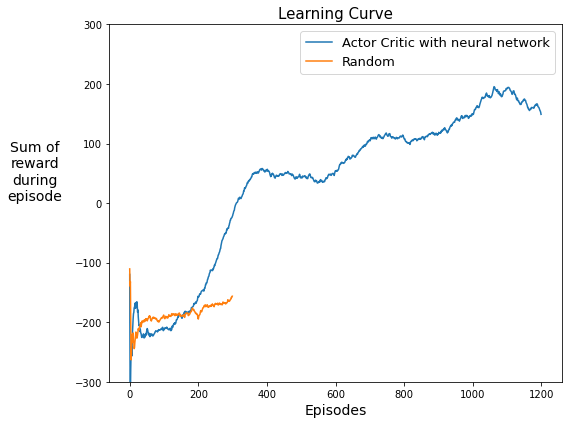

In [13]:
plot_result([
    {"data_path": "results/sum_reward_actor_critic_agent.npy", "data_legend": "Actor Critic with neural network"}, 
    {"data_path": "results/sum_reward_random_agent.npy", "data_legend": "Random"}
])